In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
df = pd.read_csv("JPM.csv") 

In [ ]:
df.dropna(inplace=True)

In [ ]:
df1=df.reset_index()['Close']

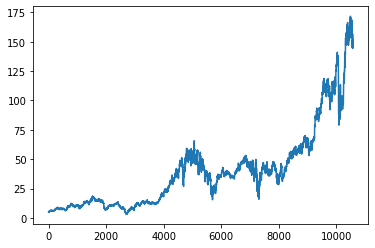

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
import numpy as np

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(6875, 3703)

In [ ]:
train_data

array([[0.00986929],
       [0.01008921],
       [0.01052907],
       ...,
       [0.2794157 ],
       [0.27300257],
       [0.27858437]])

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(6824, 50)
(6824,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(3652, 50)
(3652,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(50,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
107/107 [==============================] - 22s 140ms/step - loss: 7.9649e-04 - val_loss: 0.0075
Epoch 2/100
107/107 [==============================] - 14s 127ms/step - loss: 1.3645e-04 - val_loss: 0.0070
Epoch 3/100
107/107 [==============================] - 14s 132ms/step - loss: 1.2159e-04 - val_loss: 0.0054
Epoch 4/100
107/107 [==============================] - 14s 127ms/step - loss: 1.0424e-04 - val_loss: 0.0034
Epoch 5/100
107/107 [==============================] - 14s 127ms/step - loss: 9.8208e-05 - val_loss: 0.0036
Epoch 6/100
107/107 [==============================] - 15s 138ms/step - loss: 9.1227e-05 - val_loss: 0.0073
Epoch 7/100
107/107 [==============================] - 14s 128ms/step - loss: 9.3554e-05 - val_loss: 0.0051
Epoch 8/100
107/107 [==============================] - 14s 128ms/step - loss: 7.6026e-05 - val_loss: 0.0035
Epoch 9/100
107/107 [==============================] - 14s 128ms/step - loss: 7.2688e-05 - val_loss: 0.0019
Epoch 10/100
107/107 [======

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

27.880607422556892

In [ ]:
math.sqrt(mean_squared_error(ytest,test_predict))

74.6352153070611

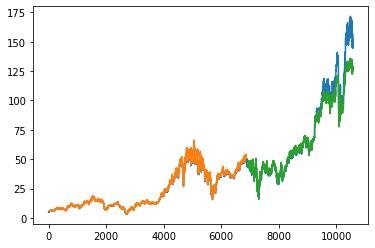

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=50
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

3703

In [ ]:
x_input=test_data[3653:].reshape(1,-1)
x_input.shape

(1, 50)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=50
i=0
while(i<100):
    
    if(len(temp_input)>50):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.718698]
51
1 day input [0.93248422 0.91081022 0.89406492 0.90683173 0.91045395 0.91377926
 0.91912357 0.92197381 0.92149876 0.9210237  0.92025182 0.94014428
 0.97654466 0.95249547 0.96282774 0.97256616 0.97351627 0.97452573
 0.98016688 0.97891985 0.91752026 0.8782103  0.86431516 0.85677388
 0.84145366 0.84068168 0.85006383 0.85831774 0.84281939 0.85053889
 0.86235567 0.87749767 0.87031266 0.86294942 0.88587037 0.88889883
 0.9060004  0.9098602  0.9060004  0.89394614 0.88545474 0.89869661
 0.90035926 0.87916032 0.88337638 0.88177308 0.86289007 0.83830649
 0.85861466 0.71869802]
1 day output [[0.6511254]]
2 day input [0.91081022 0.89406492 0.90683173 0.91045395 0.91377926 0.91912357
 0.92197381 0.92149876 0.9210237  0.92025182 0.94014428 0.97654466
 0.95249547 0.96282774 0.97256616 0.97351627 0.97452573 0.98016688
 0.97891985 0.91752026 0.8782103  0.86431516 0.85677388 0.84145366
 0.84068168 0.85006383 0.85831774 0.84281939 0.85053889 0.86235567
 0.87749767 0.87031266 0.86294942 0.8858

In [ ]:
day_new=np.arange(1,51)
day_pred=np.arange(51,81)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(df1)

10578

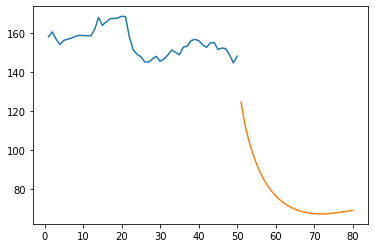

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[10528:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

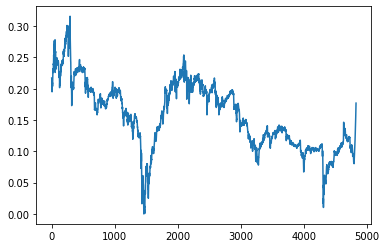

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])